In [1]:
import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

IMG_SIZE = 220

2  CPU cores


In [2]:
import os
os.chdir('/content/drive/MyDrive/Dataset')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Dataset


In [3]:
import pandas as pd
colnames = ["id_code", "diagnosis", "file_path", "file_name"]
def load_data():
    df_train_train = pd.read_csv('/content/drive/MyDrive/Dataset/train_acc2.csv', dtype=str, names=colnames, header=None)
    df_train_test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv', header=None)
    return df_train_train,df_train_test

In [4]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(3662, 4) (1929, 1) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/content/drive/MyDrive/Dataset/train_images/00...,000c1434d8d7.png
1,001639a390f0,4,/content/drive/MyDrive/Dataset/train_images/00...,001639a390f0.png
2,0024cdab0c1e,1,/content/drive/MyDrive/Dataset/train_images/00...,0024cdab0c1e.png
3,002c21358ce6,0,/content/drive/MyDrive/Dataset/train_images/00...,002c21358ce6.png
4,005b95c28852,0,/content/drive/MyDrive/Dataset/train_images/00...,005b95c28852.png
5,0083ee8054ee,4,/content/drive/MyDrive/Dataset/train_images/00...,0083ee8054ee.png


Preprocessing step

In [5]:
def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [6]:
IMG_SIZE = 220

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
      
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

    
def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 10) ,-4 ,128)
    return img 

def blur(image):
  #print(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = crop_image_from_gray(image)
  #print(image)
  image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)

  return image

def preprocess_image(image):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_LANCZOS4)
    image = circle_crop(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_LANCZOS4)
    return image
  

In [7]:
# Model parameters
#####################
BATCH_SIZE = 32
EPOCHS = 15
WARMUP_EPOCHS = 1
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = IMG_SIZE
WIDTH = IMG_SIZE
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 15
#ES_PATIENCE = 5
RLROP_PATIENCE = 15
#RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [8]:
#preprocessing_function = preprocess_image,
#####################

def img_generator(train):
    
    train_datagen=ImageDataGenerator(rescale=1./255,
                                    validation_split = 0.1)

    train_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="/content/drive/MyDrive/Dataset/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    valid_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="/content/drive/MyDrive/Dataset/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",   
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    return train_generator,valid_generator

In [9]:
#####################
train_generator,valid_generator = img_generator(df_train_train)

Found 3296 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


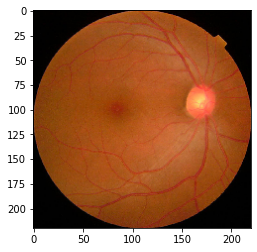

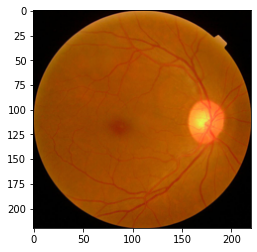

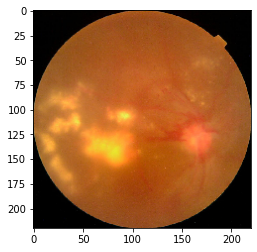

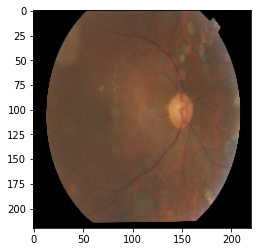

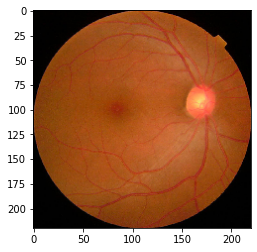

In [10]:
from google.colab.patches import cv2_imshow
import random

x,y = train_generator.next()
for i in range(5):
  image = x[random.randint(0, len(x)-1)]
  plt.imshow(image)
  plt.show()

In [11]:
from keras.layers import Dense, Dropout, Flatten, Add, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D
from keras.layers. normalization import BatchNormalization

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.load_weights('/content/drive/MyDrive/Program/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)

    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [12]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = True

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 109, 109, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 109, 109, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 109, 109, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [13]:
#####################
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

103 11


In [14]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history
#BATCH_SIZE = 64
#EPOCHS = 100
#STEPS = 200

#train_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,  verbose=1, validation_split=0.1, shuffle = True, validation_batch_size=16, validation_freq=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


103/103 [==============================] - 3230s 31s/step - loss: 0.9898 - accuracy: 0.6577 - val_loss: 1.3065 - val_accuracy: 0.6960


In [15]:
'''for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()'''

'for layer in model.layers:\n    layer.trainable = True\n\nes = EarlyStopping(monitor=\'val_loss\', mode=\'min\', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)\nrlrop = ReduceLROnPlateau(monitor=\'val_loss\', mode=\'min\', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)\n\ncallback_list = [es, rlrop]\noptimizer = optimizers.Adam(lr=LEARNING_RATE)\nmodel.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=[\'accuracy\'])\nmodel.summary()'

In [16]:
'''from keras.callbacks import ModelCheckpoint

filepath="weights-improvement-part5-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=3)
callbacks_list = [checkpoint]'''

'from keras.callbacks import ModelCheckpoint\n\nfilepath="weights-improvement-part5-{epoch:02d}-{val_accuracy:.2f}.hdf5"\ncheckpoint = ModelCheckpoint(filepath, monitor=\'val_acc\', verbose=1, save_best_only=False, save_weights_only=False, mode=\'auto\', period=3)\ncallbacks_list = [checkpoint]'

In [17]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
103/103 [==============================] - 2899s 28s/step - loss: 0.5966 - accuracy: 0.7873 - val_loss: 0.8987 - val_accuracy: 0.7301
Epoch 2/15
103/103 [==============================] - 2874s 28s/step - loss: 0.4855 - accuracy: 0.8083 - val_loss: 1.1524 - val_accuracy: 0.7784
Epoch 3/15
 21/103 [=====>........................] - ETA: 36:52 - loss: 0.4207 - accuracy: 0.8542

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

In [ ]:

cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

In [ ]:

x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

In [ ]:
#model.save("sample_train.h5")